For each input image (.jpg), a corresponding text file (.txt) exists. The first line of each text file specifies the image's dimensions (row and column). We will summarize the dimensions of all images and verify if they are consistent across the dataset.

In [ ]:
import os


def check_dims(filename: str):
    f = open(filename)
    content = f.readlines()
    rows, cols = map(int, content[0].split(' '))
    return rows, cols


input_path = "./sampleCaptchas/input/"
row_num = []
col_num = []
for root, dirs, files in os.walk((os.path.normpath(input_path)), topdown=False):
    for name in files:
        if name.endswith('.txt'):
            filename = os.path.join(root, name)
            rows, cols = check_dims(filename)
            row_num.append(rows)
            col_num.append(cols)

if row_num.count(row_num[0]) == len(row_num):
    print("all the rows are the same!")

if col_num.count(col_num[0]) == len(col_num):
    print("all the cols are the same!")

rows = row_num[0]
cols = col_num[0]


all the rows are the same!
all the cols are the same!


During our investigation, we identified missing ground truth data for input21.jpg and input100.jpg. Additionally, input100.jpg lacked a corresponding input100.txt file. We have manually completed this missing data.

For each image, we need to identify the character's position. To illustrate, four images will be randomly selected for visualization.

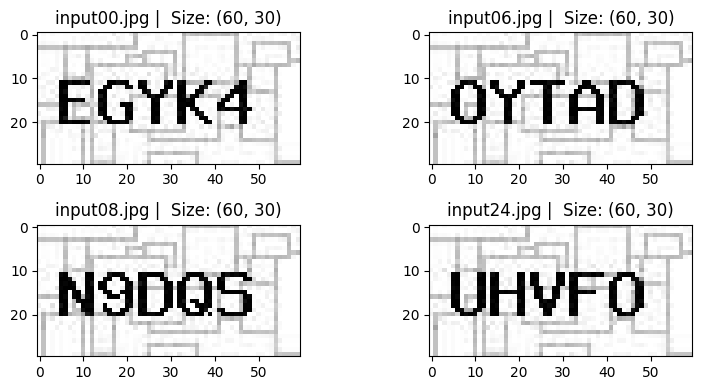

In [ ]:
import matplotlib.pyplot as plt

img_id = ["00", "06", "08", "24"]
img_dir = "./sampleCaptchas/input/"
fig, axes = plt.subplots(2, 2, figsize=(8, 4))

for i in range(len(img_id)):
    row = i // 2
    col = i % 2
    filename = "input" + img_id[i] + ".jpg"
    image_path = os.path.join(img_dir, filename)
    img = Image.open(image_path)
    axes[row, col].imshow(img)
    axes[row, col].set_title(f'{filename} |  Size: {img.size}')
    axes[row, col].axis()

plt.tight_layout()
plt.show()

image_00_path = "./sampleCaptchas/input/input00.txt"
image_06_path = "./sampleCaptchas/input/input06.txt"


Next, we will investigate the occurrences of each character.

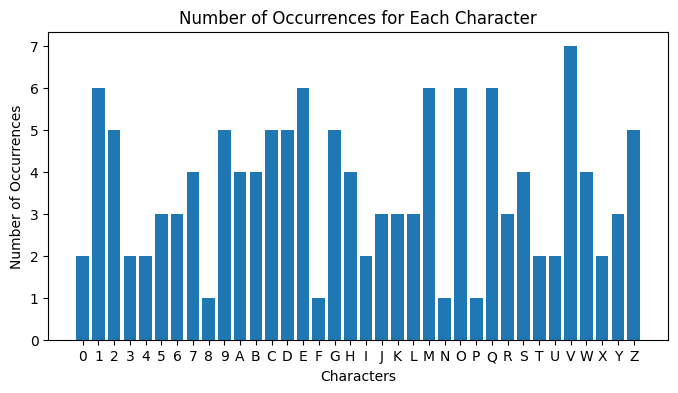

In [54]:
character_counts = {}
max_length = 0
total_samples = 0
label_dir = "./sampleCaptchas/output/"

#mannually add the labels of input21.jpg and input100.jpg to the output folder to searve as ground truth
with open("./sampleCaptchas/output/output21.txt", "w") as f:
    f.write("CL69V")
with open("./sampleCaptchas/output/output100.txt", "w") as f:
    f.write("YMB1Q")

for filename in os.listdir(label_dir):
    # Extract characters from the filename
    with open(os.path.join(label_dir,filename), "r") as f:
        label = f.read()
        label = label.strip()
        characters = list(label)

        for char in characters:
            character_counts[char] = character_counts.get(char, 0) + 1
characters_present = sorted(character_counts.keys())
counts = [character_counts[char] for char in characters_present]

plt.figure(figsize=(8, 4))
plt.bar(characters_present, counts)
plt.xlabel('Characters')
plt.ylabel('Number of Occurrences')
plt.title('Number of Occurrences for Each Character')
plt.show()

Based on the character occurrences, we split the input folder into train and test datasets, ensuring each character appears at least once in the training set.

In [52]:
train_id = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "12", "13", "14", "15", "16", "17", "19", "20", "21", "22", "23", "24"]
test_id = ["00", "11", "18", "100"]
print("the number of samples in all is", len(train_id)+len(test_id))

the number of samples in all is 26


Assuming the use of third-party libraries is allowed, readily available free and open-source tools like Tesseract OCR and EasyOCR offer convenient solutions.

In [ ]:
from PIL import Image
import pytesseract
import os
import filecmp
import easyocr


class Captcha(object):

    def __init__(self, method: str):
        self.method = method

    def __call__(self, im_path: str, save_path: str):
        """
        Algo for inference
        args:
            im_path: .jpg image path to load and to infer
            save_path: output file path to save the one-line outcome
        """
        if self.method == "Tesseract_OCR":
            img = Image.open(im_path)
            text = pytesseract.image_to_string(img)

        elif self.method == "EasyOCR":
            reader = easyocr.Reader(['en'])
            results = reader.readtext(im_path)
            text = results[0][1]

        with open(save_path, "w") as f:
            f.write(text)

    def detection(self, im_dir: str, save_dir: str):
        for root, dirs, files in os.walk(
            (os.path.normpath(im_dir)), topdown=False
        ):
            for name in files:
                if name.endswith('.jpg'):
                    img_filename = os.path.join(root, name)
                    save_filename = os.path.join(
                        save_dir, "pre" + name[5:-4] + ".txt"
                    )
                    self.__call__(img_filename, save_filename)

    @staticmethod
    def evaluation(save_dir: str, label_dir: str):
        unlabelled = []
        cnt = 0
        success = 0
        for root, dirs, files in os.walk(
            (os.path.normpath(save_dir)), topdown=False
        ):
            for name in files:
                if name.endswith('.txt'):
                    pre_filename = os.path.join(root, name)
                    label_filename = os.path.join(
                        label_dir, "output" + name[3:]
                    )
                    if os.path.isfile(label_filename):
                        cnt += 1
                        with open(pre_filename, "r") as f:
                            pre = f.read()
                            pre = pre.strip()
                        with open(label_filename, "r") as f:
                            label = f.read()
                            label = label.strip()
                        if pre == label:
                            success += 1
                    else:
                        unlabelled.append(name)

        score = success / cnt
        return score, unlabelled


#Tesseract_OCR
captcha_detect = Captcha("Tesseract_OCR")
im_dir = "./sampleCaptchas/input/"
save_dir = "./sampleCaptchas/pre_tesseractocr_1/"
captcha_detect.detection(im_dir=im_dir, save_dir=save_dir)

label_dir = "./sampleCaptchas/output/"
score, unlabelled = captcha_detect.evaluation(save_dir, label_dir)
print("precision of Tesseract_OCR score is", score)
print("unlabelled data of Tesseract_OCR is", unlabelled)

#Easy OCR
captcha_detect = Captcha("EasyOCR")
im_dir = "./sampleCaptchas/input/"
save_dir = "./sampleCaptchas/pre_easyocr_1/"
captcha_detect.detection(im_dir=im_dir, save_dir=save_dir)

label_dir = "./sampleCaptchas/output/"
score, unlabelled = captcha_detect.evaluation(save_dir, label_dir)
print("precision of Easy OCR score is", score)
print("unlabelled data of Easy OCR is", unlabelled)

precision of Tesseract_OCR score is 0.3076923076923077
unlabelled data of Tesseract_OCR is []
precision of Easy OCR score is 0.38461538461538464
unlabelled data of Easy OCR is []


The initial results indicate low detection accuracy. Therefore, we will process the images using PIL before passing them to the OCR engine again.

In [ ]:
class Captcha(object):

    def __init__(self, method: str):
        self.method = method

    def __call__(self, im_path: str, save_path: str):
        """
        Algo for inference
        args:
            im_path: .jpg image path to load and to infer
            save_path: output file path to save the one-line outcome
        """
        if self.method == "Tesseract_OCR":
            img = Image.open(im_path)
            text = pytesseract.image_to_string(img)

        elif self.method == "EasyOCR":
            reader = easyocr.Reader(['en'])
            results = reader.readtext(im_path)
            for result in results:
                text = result[1]

        with open(save_path, "w") as f:
            f.write(text)

    def detection(self, im_dir: str, save_dir: str):
        for root, dirs, files in os.walk(
            (os.path.normpath(im_dir)), topdown=False
        ):
            for name in files:
                if name.endswith('.jpg'):
                    img_filename = os.path.join(root, name)
                    save_filename = os.path.join(
                        save_dir, "pre" + name[5:-4] + ".txt"
                    )
                    self.__call__(img_filename, save_filename)

    @staticmethod
    def evaluation(save_dir: str, label_dir: str):
        unlabelled = []
        cnt = 0
        success = 0
        for root, dirs, files in os.walk(
            (os.path.normpath(save_dir)), topdown=False
        ):
            for name in files:
                if name.endswith('.txt'):
                    pre_filename = os.path.join(root, name)
                    label_filename = os.path.join(
                        label_dir, "output" + name[3:]
                    )
                    if os.path.isfile(label_filename):
                        cnt += 1
                        with open(pre_filename, "r") as f:
                            pre = f.read()
                            pre = pre.strip()
                        with open(label_filename, "r") as f:
                            label = f.read()
                            label = label.strip()
                        if pre == label:
                            success += 1
                    else:
                        unlabelled.append(name)

        score = success / cnt
        return score, unlabelled

    @staticmethod
    def preprocess(im_dir: str, process_dir: str):
        for root, dirs, files in os.walk(
            (os.path.normpath(im_dir)), topdown=False
        ):
            for name in files:
                if name.endswith('.jpg'):
                    img_filename = os.path.join(root, name)
                    img = Image.open(img_filename)
                    # Convert to grayscale
                    img = img.convert('L')
                    # Sharpen image
                    img = img.filter(ImageFilter.SHARPEN)
                    process_filename = os.path.join(process_dir, name)
                    img.save(process_filename)


#Tesseract_OCR
captcha_detect = Captcha("Tesseract_OCR")
im_dir = "./sampleCaptchas/input/"
process_dir = "./sampleCaptchas/process_imgs/"
save_dir = "./sampleCaptchas/pre_tesseractocr_2/"
captcha_detect.preprocess(im_dir=im_dir, process_dir=process_dir)
captcha_detect.detection(im_dir=process_dir, save_dir=save_dir)

label_dir = "./sampleCaptchas/output/"
score, unlabelled = captcha_detect.evaluation(save_dir, label_dir)
print("precision of Tesseract_OCR score after preprocessing is", score)
print("unlabelled data of Tesseract_OCR after preprocessing is", unlabelled)

#Easy OCR
captcha_detect = Captcha("EasyOCR")
im_dir = "./sampleCaptchas/input/"
save_dir = "./sampleCaptchas/pre_easyocr_2/"
captcha_detect.detection(im_dir=process_dir, save_dir=save_dir)

label_dir = "./sampleCaptchas/output/"
score, unlabelled = captcha_detect.evaluation(save_dir, label_dir)
print("precision of Easy OCR score after preprocessing is", score)
print("unlabelled data of Easy OCR after preprocessing is", unlabelled)

precision of Tesseract_OCR score after preprocessing is 0.23076923076923078
unlabelled data of Tesseract_OCR after preprocessing is []
precision of Easy OCR score after preprocessing is 0.5384615384615384
unlabelled data of Easy OCR after preprocessing is []


Following PIL-based data processing, Tesseract OCR accuracy decreased, while EasyOCR's accuracy improved to 0.5, which remains unsatisfactory. Given the small dataset size, we will employ a low-complexity model to mitigate overfitting. As a next step, we will attempt image segmentation.

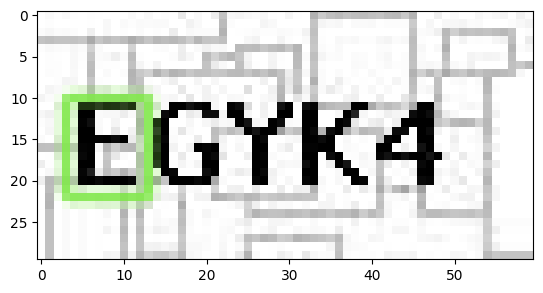

In [ ]:
import os
import numpy as np
import cv2
import random
from matplotlib import pyplot as plt


def plot_one_box(x, img, color=None, label=None, line_thickness=1):
    # Plots one bounding box on image img
    tl = line_thickness or round(
        0.002 * (img.shape[0] + img.shape[1]) / 2
    ) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)


img_path = "./sampleCaptchas/input/input00.jpg"

image = cv2.imread(img_path)

plot_one_box([3, 10, 13, 22], image)
plt.imshow(image)

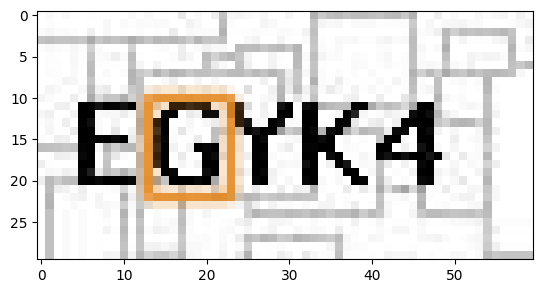

In [11]:
import os
import numpy as np
import cv2
import random
from matplotlib import pyplot as plt


def plot_one_box(x, img, color=None, label=None, line_thickness=1):
    # Plots one bounding box on image img
    tl = line_thickness or round(
        0.002 * (img.shape[0] + img.shape[1]) / 2
    ) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)


img_path = "./sampleCaptchas/input/input00.jpg"

image = cv2.imread(img_path)

plot_one_box([13, 10, 23, 22], image)
plt.imshow(image)

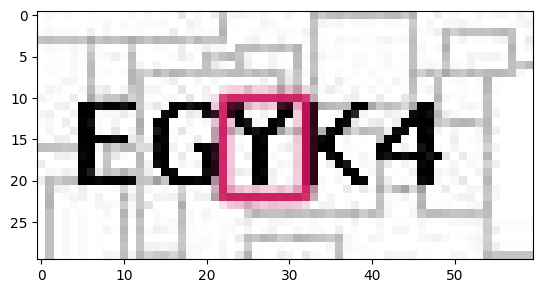

In [12]:
import os
import numpy as np
import cv2
import random
from matplotlib import pyplot as plt


def plot_one_box(x, img, color=None, label=None, line_thickness=1):
    # Plots one bounding box on image img
    tl = line_thickness or round(
        0.002 * (img.shape[0] + img.shape[1]) / 2
    ) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)


img_path = "./sampleCaptchas/input/input00.jpg"

image = cv2.imread(img_path)

plot_one_box([22, 10, 32, 22], image)
plt.imshow(image)

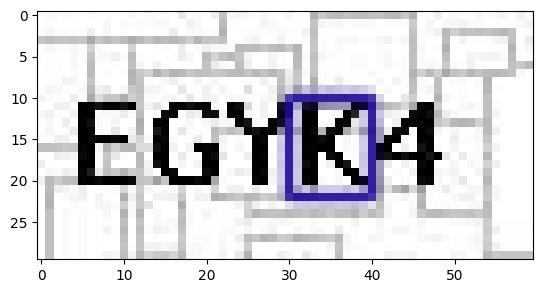

In [13]:
import os
import numpy as np
import cv2
import random
from matplotlib import pyplot as plt


def plot_one_box(x, img, color=None, label=None, line_thickness=1):
    # Plots one bounding box on image img
    tl = line_thickness or round(
        0.002 * (img.shape[0] + img.shape[1]) / 2
    ) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)


img_path = "./sampleCaptchas/input/input00.jpg"

image = cv2.imread(img_path)

plot_one_box([30, 10, 40, 22], image)
plt.imshow(image)

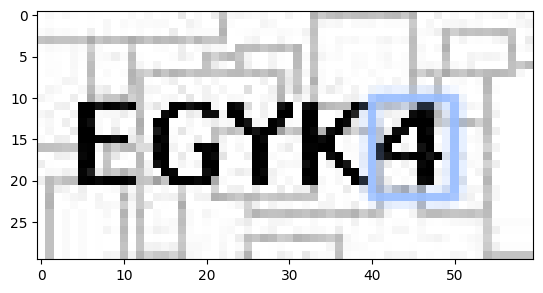

In [14]:
import os
import numpy as np
import cv2
import random
from matplotlib import pyplot as plt


def plot_one_box(x, img, color=None, label=None, line_thickness=1):
    # Plots one bounding box on image img
    tl = line_thickness or round(
        0.002 * (img.shape[0] + img.shape[1]) / 2
    ) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)


img_path = "./sampleCaptchas/input/input00.jpg"

image = cv2.imread(img_path)

plot_one_box([40, 10, 50, 22], image)
plt.imshow(image)

As an initial trial, we will use a CLIP image embedding model to extract image features.

In [4]:
from PIL import Image
import numpy as np
import os
import torch
import clip
import cv2
from sklearn.linear_model import LogisticRegression


class Captcha(object):

    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.embedding_model, self.preprocess = clip.load(
            "./ckpts/ViT-B-32.pt", device=self.device
        )
        self.classfier = LogisticRegression()

    @staticmethod
    def evaluation(pre_dir: str, label_dir: str):
        unlabelled = []
        cnt = 0
        success = 0
        for root, dirs, files in os.walk(
            (os.path.normpath(save_dir)), topdown=False
        ):
            for name in files:
                if name.endswith('.txt'):
                    pre_filename = os.path.join(root, name)
                    label_filename = os.path.join(
                        label_dir, "output" + name[3:]
                    )
                    if os.path.isfile(label_filename):
                        cnt += 1
                        with open(pre_filename, "r") as f:
                            pre = f.read()
                            pre = pre.strip()
                        with open(label_filename, "r") as f:
                            label = f.read()
                            label = label.strip()
                        if pre == label:
                            success += 1
                    else:
                        unlabelled.append(name)

        score = success / cnt
        return score, unlabelled

    def load_data(self, img_dir: str, label_dir: str, train_id: list):
        feas_train = []
        labels_train = []
        cnt = 0

        for img_name in train_id:
            img_path = os.path.join(img_dir, "input" + img_name + ".jpg")
            label_path = os.path.join(label_dir, "output" + img_name + ".txt")

            with open(label_path, "r") as f:
                label = f.read()
                label = label.strip()
                characters = list(label)
            labels_train.extend(characters)

            # Split the image into segments
            image = cv2.imread(img_path)

            segments = [
                image[10:22, 3:13], image[10:22, 13:23], image[10:22, 22:32],
                image[10:22, 30:40], image[10:22, 40:50]
            ]
            for img_seg in segments:
                cnt += 1
                cv2.imwrite('./segments/' + str(cnt) + '.png', img_seg)
                img_seg = self.preprocess(
                    Image.open('./segments/' + str(cnt) + '.png')
                ).unsqueeze(0).to(self.device)
                with torch.no_grad():
                    fea_seg = self.embedding_model.encode_image(
                        img_seg
                    )  #dimension 512
                feas_train.extend(fea_seg.cpu().numpy())

        return np.array(feas_train), np.array(labels_train)

    def train(self, feas, labels):
        print(feas.shape)
        print(labels.shape)
        self.classfier.fit(feas, labels)


#Tesseract_OCR
train_id = [
    "01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "12", "13",
    "14", "15", "16", "17", "19", "20", "21", "22", "23", "24"
]
captcha_detect = Captcha()
im_dir = "./sampleCaptchas/input/"
label_dir = "./sampleCaptchas/output/"

feas, labels = captcha_detect.load_data(im_dir, label_dir, train_id)
captcha_detect.train(feas, labels)

(110, 512)
(110,)


/home/jxy/miniconda3/envs/test/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The classifier failed to converge within a certain number of steps, likely due to the selection of improper features.

In [7]:
from PIL import Image
import numpy as np
import os
import cv2
from sklearn.linear_model import LogisticRegression


class Captcha(object):

    def __init__(self):
        self.classfier = LogisticRegression()

    def __call__(self, im_path: str, save_path: str):
        """
        Algo for inference
        args:
            im_path: .jpg image path to load and to infer
            save_path: output file path to save the one-line outcome
        """

        image = cv2.imread(im_path)

        segments = [
            image[10:22, 3:13], image[10:22, 13:23], image[10:22, 22:32],
            image[10:22, 30:40], image[10:22, 40:50]
        ]

        feas_test = []
        for img_seg in segments:
            mean_fea = np.mean(img_seg, axis=2)
            mean_fea = mean_fea.flatten()
            feas_test.append(mean_fea)

        text = self.classfier.predict(np.array(feas_test))
        text = "".join(text)

        with open(save_path, "w") as f:
            f.write(text)

    def load_data(
        self, img_dir: str, label_dir: str, train_id: list, vector_size=32
    ):
        feas_train = []
        labels_train = []

        for img_name in train_id:
            img_path = os.path.join(img_dir, "input" + img_name + ".jpg")
            label_path = os.path.join(label_dir, "output" + img_name + ".txt")

            with open(label_path, "r") as f:
                label = f.read()
                label = label.strip()
                characters = list(label)
            labels_train.extend(characters)

            # Split the image into segments
            image = cv2.imread(img_path)

            segments = [
                image[10:22, 3:13], image[10:22, 13:23], image[10:22, 22:32],
                image[10:22, 30:40], image[10:22, 40:50]
            ]

            for img_seg in segments:
                mean_fea = np.mean(img_seg, axis=2)
                mean_fea = mean_fea.flatten()
                feas_train.append(mean_fea)

        return np.array(feas_train), np.array(labels_train)

    def train(self, feas, labels):
        self.classfier.fit(feas, labels)

    def predict(self, im_dir, save_dir, test_id):

        for img_name in test_id:
            img_path = os.path.join(im_dir, "input" + img_name + ".jpg")
            save_path = os.path.join(save_dir, "output" + img_name + ".txt")
            self.__call__(img_path, save_path)

    @staticmethod
    def evaluation(save_dir: str, label_dir: str):
        unlabelled = []
        cnt = 0
        success = 0
        for root, dirs, files in os.walk(
            (os.path.normpath(save_dir)), topdown=False
        ):
            for name in files:
                if name[-4:] == '.txt':
                    pre_filename = os.path.join(root, name)
                    label_filename = os.path.join(label_dir, name)
                    print("label", label_filename)
                    if os.path.isfile(label_filename):
                        cnt += 1
                        with open(pre_filename, "r") as f:
                            pre = f.read()
                            pre = pre.strip()
                        with open(label_filename, "r") as f:
                            label = f.read()
                            label = label.strip()
                        if pre == label:
                            success += 1
                    else:
                        unlabelled.append(name)

        score = success / cnt
        return score, unlabelled


train_id = [
    "01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "12", "13",
    "14", "15", "16", "17", "19", "20", "21", "22", "23", "24"
]
captcha_detect = Captcha()
im_dir = "./sampleCaptchas/input/"
label_dir = "./sampleCaptchas/output/"

feas, labels = captcha_detect.load_data(im_dir, label_dir, train_id)
captcha_detect.train(feas, labels)

test_id = ["00", "11", "18", "100"]
save_dir = "./sampleCaptchas/pre_classifier/"
captcha_detect.predict(im_dir, save_dir, test_id)
score, unlabelled = captcha_detect.evaluation(save_dir, label_dir)
print("The prediction score is", score)
print("Unlabelled data is", unlabelled)


label ./sampleCaptchas/output/output00.txt
label ./sampleCaptchas/output/output18.txt
label ./sampleCaptchas/output/output100.txt
label ./sampleCaptchas/output/output11.txt
The prediction score is 0.0
Unlabelled data is []


The prediction accuracy on the test dataset is low. Given the small dataset size, we are employing a more direct character detection method. This involves sliding each letter (mask) across the image, calculating the pixel-wise difference at each position, and summing these differences to obtain a fitness score. For each letter, we record the position yielding the maximum score. The top-scoring positions are then used to reconstruct the CAPTCHA text.

In [9]:
import os
import cv2
from sklearn.linear_model import LogisticRegression


class Captcha(object):

    def __init__(self):
        self.template = {}

    def __call__(self, im_path: str, save_path: str):
        """
        Algo for inference
        args:
            im_path: .jpg image path to load and to infer
            save_path: output file path to save the one-line outcome
        """

        image = cv2.imread(im_path)

        segments = [
            image[10:22, 3:13], image[10:22, 13:23], image[10:22, 22:32],
            image[10:22, 30:40], image[10:22, 40:50]
        ]
        text = ""
        for img_seg in segments:
            score = {}
            for char in self.template.keys():
                template_char = self.template[char]

                min_value = 1e6
                for i in range(len(template_char)):
                    diff_i = cv2.subtract(template_char[i], img_seg)
                    mean_diff = np.sum(
                        np.square(diff_i)
                    ) / (diff_i.shape[0] * diff_i.shape[1] * diff_i.shape[2])
                    if mean_diff < min_value:
                        min_value = mean_diff
                score[char] = min_value
            score_sorted = sorted(score.items(), key=lambda x: x[1])
            text = text.join(score_sorted[0][0])

        with open(save_path, "w") as f:
            f.write(text)

    def extract_template(self, img_dir: str, label_dir: str, train_id: list):

        for img_name in train_id:
            img_path = os.path.join(img_dir, "input" + img_name + ".jpg")
            label_path = os.path.join(label_dir, "output" + img_name + ".txt")

            with open(label_path, "r") as f:
                label = f.read()
                label = label.strip()
                characters = list(label)

            # Split the image into segments
            image = cv2.imread(img_path)
            segments = [
                image[10:22, 3:13], image[10:22, 13:23], image[10:22, 22:32],
                image[10:22, 30:40], image[10:22, 40:50]
            ]

            for i in range(len(characters)):
                if characters[i] not in self.template.keys():
                    self.template[characters[i]] = []
                self.template[characters[i]].append(segments[i])

    def predict(self, im_dir, save_dir, test_id):

        for img_name in test_id:
            img_path = os.path.join(im_dir, "input" + img_name + ".jpg")
            save_path = os.path.join(save_dir, "output" + img_name + ".txt")
            self.__call__(img_path, save_path)

    @staticmethod
    def evaluation(save_dir: str, label_dir: str):
        unlabelled = []
        cnt = 0
        success = 0
        for root, dirs, files in os.walk(
            (os.path.normpath(save_dir)), topdown=False
        ):
            for name in files:
                if name[-4:] == '.txt':
                    pre_filename = os.path.join(root, name)
                    label_filename = os.path.join(label_dir, name)
                    if os.path.isfile(label_filename):
                        cnt += 1
                        with open(pre_filename, "r") as f:
                            pre = f.read()
                            pre = pre.strip()
                        with open(label_filename, "r") as f:
                            label = f.read()
                            label = label.strip()
                        if pre == label:
                            success += 1
                    else:
                        unlabelled.append(name)

        score = success / cnt
        return score, unlabelled


train_id = [
    "01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "12", "13",
    "14", "15", "16", "17", "19", "20", "21", "22", "23", "24"
]
captcha_detect = Captcha()
im_dir = "./sampleCaptchas/input/"
label_dir = "./sampleCaptchas/output/"

captcha_detect.extract_template(im_dir, label_dir, train_id)

test_id = ["00", "11", "18", "100"]
save_dir = "./sampleCaptchas/pre_classifier/"
captcha_detect.predict(im_dir, save_dir, test_id)
score, unlabelled = captcha_detect.evaluation(save_dir, label_dir)
print("The prediction score is", score)
print("Unlabelled data is", unlabelled)


The prediction score is 0.0
Unlabelled data is []


Due to the low detection efficiency, we will enhance the process by adding image preprocessing.

In [10]:
from PIL import Image
import numpy as np
import os
import cv2
from sklearn.linear_model import LogisticRegression


class Captcha(object):

    def __init__(self):
        self.template = {}

    def __call__(self, im_path: str, save_path: str):
        """
        Algo for inference
        args:
            im_path: .jpg image path to load and to infer
            save_path: output file path to save the one-line outcome
        """

        image = cv2.imread(im_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.adaptiveThreshold(
            image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145,
            0
        )
        kernel_close = np.ones((5, 5), np.uint8)
        image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel_close)
        kernel_dilate = np.ones((2, 2), np.uint8)
        image = cv2.dilate(image, kernel_dilate, iterations=1)
        image = cv2.GaussianBlur(image, (5, 5), 0)
        segments = [
            image[10:22, 3:13], image[10:22, 13:23], image[10:22, 22:32],
            image[10:22, 30:40], image[10:22, 40:50]
        ]
        text = ""
        for img_seg in segments:
            score = {}
            for char in self.template.keys():
                template_char = self.template[char]

                min_value = 1e6
                for i in range(len(template_char)):
                    diff_i = cv2.subtract(template_char[i], img_seg)
                    mean_diff = np.sum(np.square(diff_i)
                                      ) / (diff_i.shape[0] * diff_i.shape[1])
                    if mean_diff < min_value:
                        min_value = mean_diff
                score[char] = min_value

            score_sorted = sorted(score.items(), key=lambda x: x[1])
            text = text + score_sorted[0][0]
        with open(save_path, "w") as f:
            f.write(text)

    def extract_template(self, img_dir: str, label_dir: str, train_id: list):

        for img_name in train_id:
            img_path = os.path.join(img_dir, "input" + img_name + ".jpg")
            label_path = os.path.join(label_dir, "output" + img_name + ".txt")

            with open(label_path, "r") as f:
                label = f.read()
                label = label.strip()
                characters = list(label)

            # Split the image into segments
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.adaptiveThreshold(
                image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,
                145, 0
            )
            kernel_close = np.ones((5, 5), np.uint8)
            image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel_close)
            kernel_dilate = np.ones((2, 2), np.uint8)
            image = cv2.dilate(image, kernel_dilate, iterations=1)
            image = cv2.GaussianBlur(image, (5, 5), 0)
            segments = [
                image[10:22, 3:13], image[10:22, 13:23], image[10:22, 22:32],
                image[10:22, 30:40], image[10:22, 40:50]
            ]

            for i in range(len(characters)):
                if characters[i] not in self.template.keys():
                    self.template[characters[i]] = []
                self.template[characters[i]].append(segments[i])

    def predict(self, im_dir, save_dir, test_id):

        for img_name in test_id:
            img_path = os.path.join(im_dir, "input" + img_name + ".jpg")
            save_path = os.path.join(save_dir, "output" + img_name + ".txt")
            self.__call__(img_path, save_path)

    @staticmethod
    def evaluation(save_dir: str, label_dir: str):
        unlabelled = []
        cnt = 0
        success = 0
        for root, dirs, files in os.walk(
            (os.path.normpath(save_dir)), topdown=False
        ):
            for name in files:
                if name[-4:] == '.txt':
                    pre_filename = os.path.join(root, name)
                    label_filename = os.path.join(label_dir, name)
                    if os.path.isfile(label_filename):
                        cnt += 1
                        with open(pre_filename, "r") as f:
                            pre = f.read()
                            pre = pre.strip()
                        with open(label_filename, "r") as f:
                            label = f.read()
                            label = label.strip()
                        if pre == label:
                            success += 1
                    else:
                        unlabelled.append(name)

        score = success / cnt
        return score, unlabelled


train_id = [
    "01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "12", "13",
    "14", "15", "16", "17", "19", "20", "21", "22", "23", "24"
]
captcha_detect = Captcha()
im_dir = "./sampleCaptchas/input/"
label_dir = "./sampleCaptchas/output/"

captcha_detect.extract_template(im_dir, label_dir, train_id)

test_id = ["00", "11", "18", "100"]
save_dir = "./sampleCaptchas/pre_classifier/"
captcha_detect.predict(im_dir, save_dir, test_id)
score, unlabelled = captcha_detect.evaluation(save_dir, label_dir)
print("The prediction score is", score)
print("Unlabelled data is", unlabelled)

The prediction score is 0.0
Unlabelled data is []


To address potential noise when reading images directly, we will load the image matrix from the text file and re-test.

In [11]:
from PIL import Image
import numpy as np
import os
import cv2
from sklearn.linear_model import LogisticRegression


class Captcha(object):

    def __init__(self):
        self.template = {}

    def __call__(self, im_path: str, save_path: str):
        """
        Algo for inference
        args:
            im_path: .jpg image path to load and to infer
            save_path: output file path to save the one-line outcome
        """

        image = self.read_image(im_path)
        segments = [
            image[10:22, 3:13], image[10:22, 13:23], image[10:22, 22:32],
            image[10:22, 30:40], image[10:22, 40:50]
        ]

        text = ""
        for img_seg in segments:
            score = {}
            for char in self.template.keys():
                template_char = self.template[char]

                min_value = 1e6
                for i in range(len(template_char)):
                    diff_i = cv2.subtract(template_char[i], img_seg)
                    mean_diff = np.sum(np.square(diff_i)
                                      ) / (diff_i.shape[0] * diff_i.shape[1])
                    if mean_diff < min_value:
                        min_value = mean_diff
                score[char] = min_value

            score_sorted = sorted(score.items(), key=lambda x: x[1])
            text = text + score_sorted[0][0]

        with open(save_path, "w") as f:
            f.write(text)

    def extract_template(self, img_dir: str, label_dir: str, train_id: list):

        for img_name in train_id:
            img_path = os.path.join(img_dir, "input" + img_name + ".txt")
            label_path = os.path.join(label_dir, "output" + img_name + ".txt")

            with open(label_path, "r") as f:
                label = f.read()
                label = label.strip()
                characters = list(label)

            # Split the image into segments
            image = self.read_image(img_path)
            segments = [
                image[10:22, 3:13], image[10:22, 13:23], image[10:22, 22:32],
                image[10:22, 30:40], image[10:22, 40:50]
            ]

            for i in range(len(characters)):
                if characters[i] not in self.template.keys():
                    self.template[characters[i]] = []
                self.template[characters[i]].append(segments[i])

    def predict(self, im_dir, save_dir, test_id):

        for img_name in test_id:
            img_path = os.path.join(im_dir, "input" + img_name + ".txt")
            save_path = os.path.join(save_dir, "output" + img_name + ".txt")
            self.__call__(img_path, save_path)

    @staticmethod
    def evaluation(save_dir: str, label_dir: str):
        unlabelled = []
        cnt = 0
        success = 0
        for root, dirs, files in os.walk(
            (os.path.normpath(save_dir)), topdown=False
        ):
            for name in files:
                if name[-4:] == '.txt':
                    pre_filename = os.path.join(root, name)
                    label_filename = os.path.join(label_dir, name)
                    if os.path.isfile(label_filename):
                        cnt += 1
                        with open(pre_filename, "r") as f:
                            pre = f.read()
                            pre = pre.strip()
                        with open(label_filename, "r") as f:
                            label = f.read()
                            label = label.strip()
                        if pre == label:
                            success += 1
                    else:
                        unlabelled.append(name)

        score = success / cnt
        return score, unlabelled

    def read_image(self, filename):
        f = open(filename)
        content = f.readlines()
        rows, columns = map(int, content[0].split(' '))
        image_data = np.empty([rows, columns, 3])
        for i, line in enumerate(content[1:]):
            image_data[i, :, :] = np.array(
                [list(map(int, pixel.split(','))) for pixel in line.split(' ')]
            )
        return image_data


train_id = [
    "01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "12", "13",
    "14", "15", "16", "17", "19", "20", "21", "22", "23", "24"
]
captcha_detect = Captcha()
im_dir = "./sampleCaptchas/input/"
label_dir = "./sampleCaptchas/output/"

captcha_detect.extract_template(im_dir, label_dir, train_id)

test_id = ["00", "11", "18"]
save_dir = "./sampleCaptchas/pre_classifier/"
captcha_detect.predict(im_dir, save_dir, test_id)
score, unlabelled = captcha_detect.evaluation(save_dir, label_dir)
print("The prediction score is", score)
print("Unlabelled data is", unlabelled)


The prediction score is 0.0
Unlabelled data is []


To date, the most accurate approach on the entire dataset has been the implementation using EasyOCR. Due to time constraints, I then explored freely available open-source APIs or libraries pretrained on large datasets for robust generation. Testing the AZcaptcha API yielded 100% accuracy on the whole dataset. These results, shown below, indicate that utilizing free Web APIs can automate CAPTCHA recognition, saving both cost and time. The results are as follows.

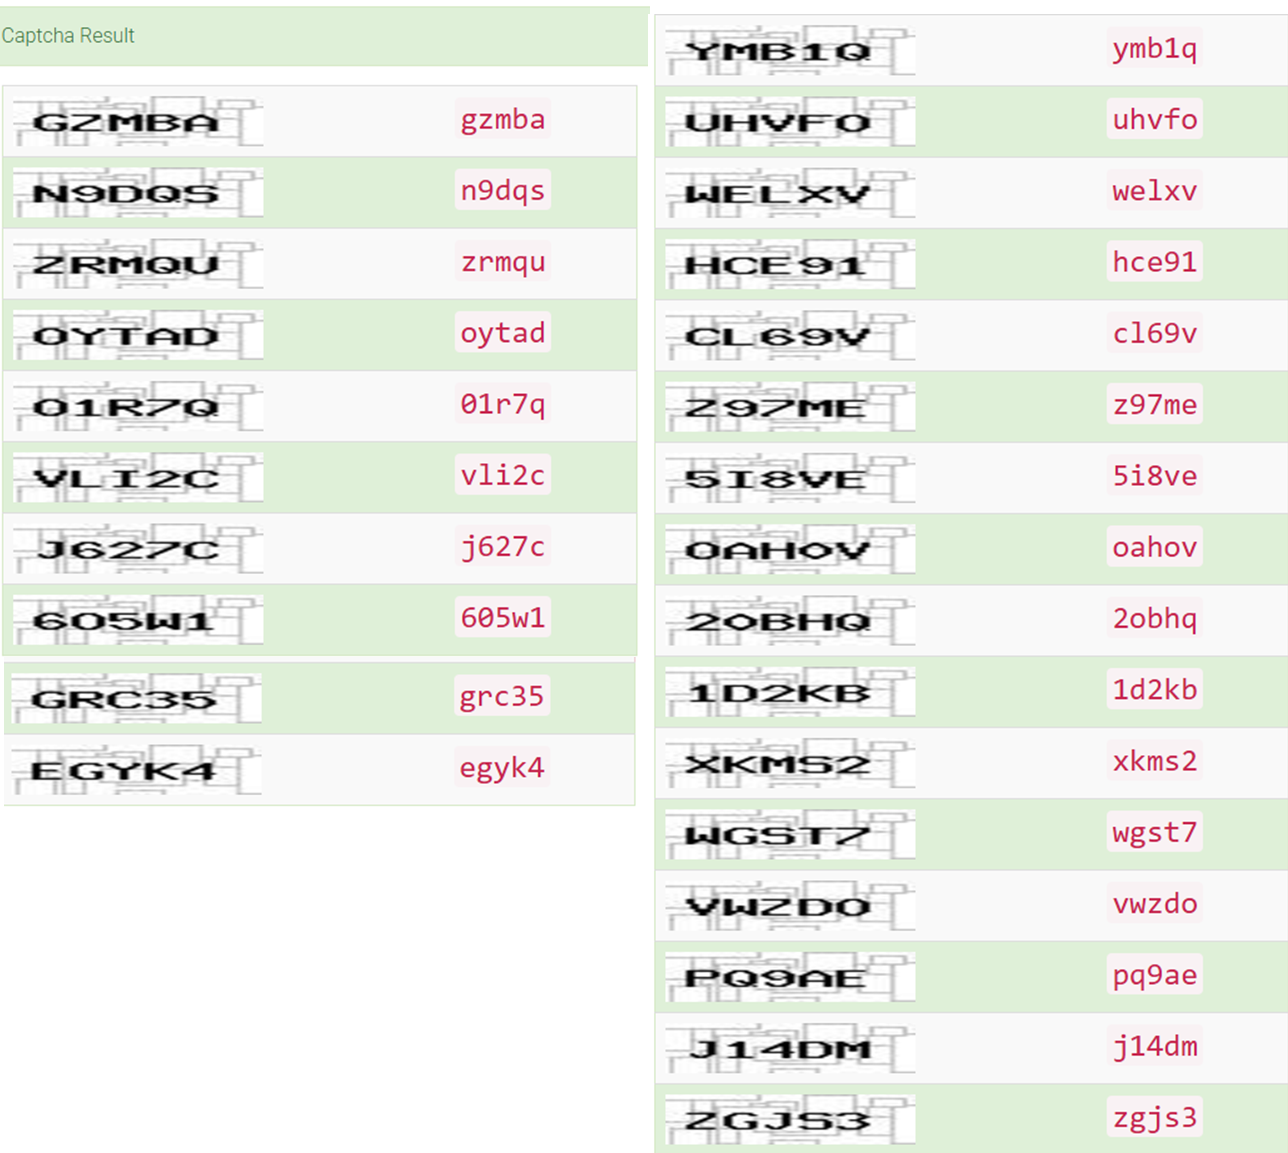

In [1]:
from IPython.display import Image

Image("./result.png")